In [1]:
import os
import glob
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
import plotly.express as px
from pointnet_loader import get_dataset, get_pretrained_model, get_class_map

## Load ModelNet10 dataset and pre-trained PointNet model

In [2]:
class_map = get_class_map() # dict, index -> class label
train_data, test_data = get_dataset()
pointnet_model = get_pretrained_model()

2022-03-29 15:56:29.892946: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-03-29 15:56:29.892973: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: snowy
2022-03-29 15:56:29.892977: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: snowy
2022-03-29 15:56:29.893076: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.103.1
2022-03-29 15:56:29.893090: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.103.1
2022-03-29 15:56:29.893093: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.103.1
2022-03-29 15:56:29.893335: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical opera

## Get a incorrect predicitons

In [3]:
# Get where pointnet made the wrong predictions
objs = []
predictions = []
true_labels = []
total = 0
for points, labels in test_data:
    preds = pointnet_model.predict(points)
    preds = tf.math.argmax(preds,-1)
    for idx, pred in enumerate(preds):
        total += 1
        if pred.numpy() != labels.numpy()[idx]:
            objs.append(points[idx].numpy())
            predictions.append(pred.numpy())
            true_labels.append(labels[idx].numpy())

In [4]:
print("Accuracy: {:.2f}%".format((1- (len(objs)/total)) * 100))

Accuracy: 80.29%


In [5]:
def visualize_point_cloud(obj, color=None):
    obj_t = list(map(list, zip(*obj)))
    fig = px.scatter_3d(x=obj_t[0], y=obj_t[1], z=obj_t[2], color=color)
    fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
    fig.show()

True Label: bathtub
Preicted: sofa


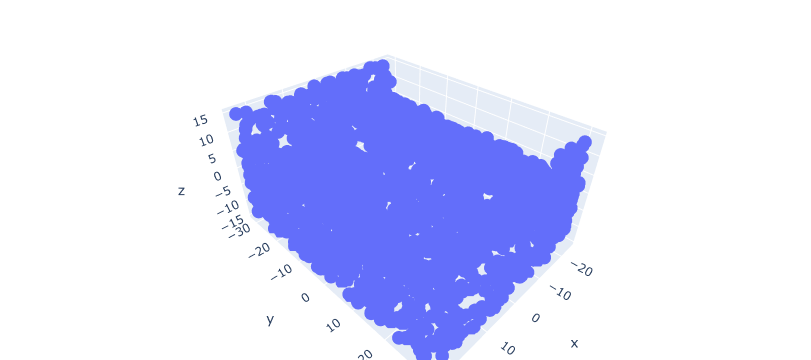

In [13]:
idx = 10
obj = objs[idx]
label = true_labels[idx]
prediction = predictions[idx]


# Visualize the actual cloud points
print("True Label: " + class_map[label])
print("Preicted: " + class_map[prediction])
visualize_point_cloud(obj)

## Farthest point sampling

In [14]:
def euclidean_distance(point1, point2):
    return np.linalg.norm(point1 - point2)

def farthest_point_sampling(points, k, starting_point=None):
    idxs = [i for i in range(len(points))]
    pts = points.copy()
    sampled_idx = []
    sampled = []
    
    if not starting_point:
        starting_point = random.sample(idxs, 1)[0]
    sampled_idx.append(starting_point)
    sampled.append(pts[starting_point])
    
    while len(sampled) < k:
        new_sample_idx = None
        new_sample = None
        max_dis = 0
        for i, pt in enumerate(pts):
            if i in sampled_idx:
                continue
            # import pdb;pdb.set_trace()
            dis = min([euclidean_distance(pt, x) for x in sampled])
            if dis > max_dis:
                max_dis = dis
                new_sample_idx = i
                new_sample = pt
        sampled_idx.append(new_sample_idx)
        sampled.append(new_sample)
        
    return sampled_idx, sampled

In [15]:
sampled_idx, sampled = farthest_point_sampling(obj, 40, 0)

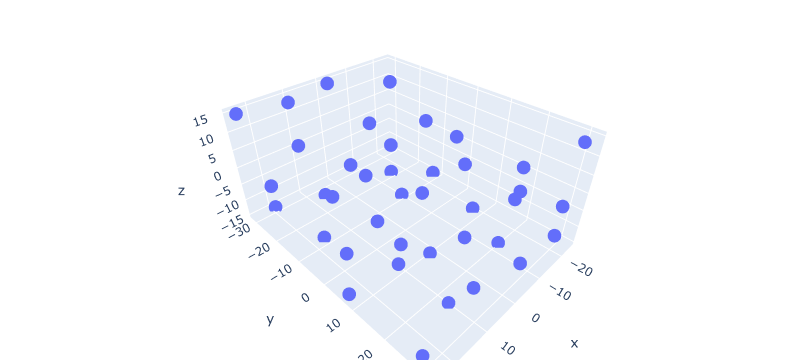

In [16]:
visualize_point_cloud(sampled)

## Create segments

In [17]:
def get_segments_from_centroids(points, centroids):
    segs = []
    for pt in obj:
        seg = None
        min_dis = float('inf')
        for i, centroid in enumerate(centroids):
            dis = euclidean_distance(pt, centroid)
            if dis < min_dis:
                min_dis = dis
                seg = i
        segs.append(seg)
    return segs
segs = get_segments_from_centroids(obj, sampled)

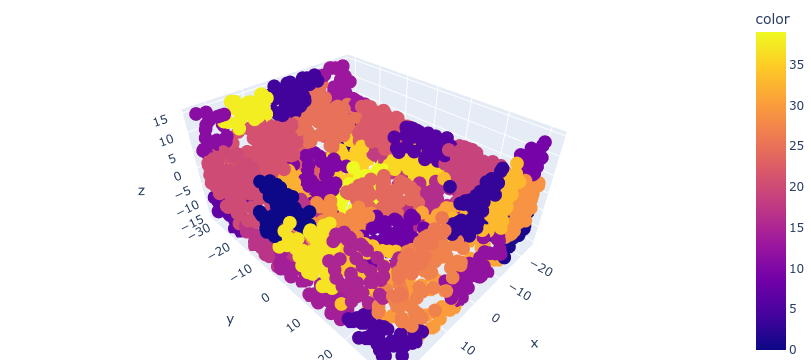

In [18]:
visualize_point_cloud(obj, color=segs)

## Get masks and maksed object

In [36]:
n_segs = len(set(segs))
ratio_masked = 0.5
mask_idx = random.sample(list(set(segs)), int(n_segs * ratio_masked))

In [37]:
import copy
def get_masked_object(obj, segs, mask_idx):
    vals = []
    for seg, point in zip(segs, obj):
        if seg not in mask_idx:
            vals.append(point)
    vals = np.resize(vals, obj.shape)
    return vals
vals = get_masked_object(obj, segs, mask_idx)

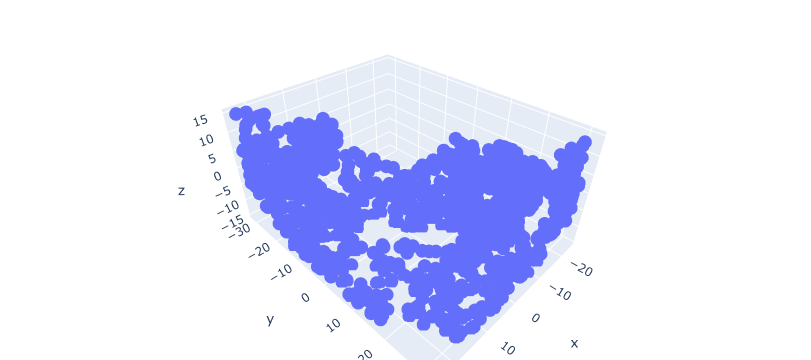

In [38]:
visualize_point_cloud(vals)

## Get probability for the class we are interested in

In [39]:
class_map

{0: 'night_stand',
 1: 'toilet',
 2: 'monitor',
 3: 'sofa',
 4: 'table',
 5: 'dresser',
 6: 'bathtub',
 7: 'desk',
 8: 'bed',
 9: 'chair'}

In [42]:
# Let's use predicted probability for each index
def get_idx_prob_pred(index, masked_obj, model):
    preds =  model.predict(np.array([masked_obj]))
    prob = preds[0][index]
    return prob, preds
prob, preds = get_idx_prob_pred(6, vals, pointnet_model)
print("label: " + class_map[tf.math.argmax(preds,-1).numpy()[0]])

label: sofa


## MCMC mask selection

In [97]:
def get_new_step(mask_idx, n_seg, num_samples=5):
    sample_idx = random.sample(range(n_seg), num_samples)
    new_mask_idx = mask_idx.copy()
    for idx in sample_idx:
        if idx in mask_idx:
            new_mask_idx.remove(idx)
        else:
            new_mask_idx.append(idx)
    return new_mask_idx
get_new_step(mask_idx, len(set(segs)), 5)

[4,
 7,
 5,
 22,
 38,
 35,
 2,
 1,
 37,
 1030,
 456,
 1195,
 427,
 325,
 14,
 39,
 9,
 19,
 30,
 31,
 16,
 8,
 23,
 33]

## MCMC algorithm

In [98]:
from tqdm import tqdm
def MCMC(total_iters, burn_in_iters, step_len, index_of_interest, obj, segments, model):
    # Start at a random mask.
    n_segs = len(set(segments))
    num_accept = 0
    ratio_masked = 0.5
    
    mask_idx = random.sample(list(set(segs)), int(n_segs * ratio_masked))
    masked_obj = get_masked_object(obj, segs, mask_idx)
    prob, preds = get_idx_prob_pred(index_of_interest, masked_obj, model)
    labels = []
    masks = []
    probs = []
    
    for i in tqdm(range(total_iters)):
        new_mask_idx = get_new_step(mask_idx, n_segs, num_samples=step_len)
        new_masked_obj = get_masked_object(obj, segs, new_mask_idx)
        new_prob, new_preds = get_idx_prob_pred(index_of_interest, new_masked_obj, model)
        
        if random.uniform(0, 1) < new_prob/prob:
            mask_idx = new_mask_idx
            masked_obj = new_masked_obj
            prob = new_prob
            preds = new_preds
            num_accept += 1
        
        if i >= burn_in_iters:
            masks.append(mask_idx)
            probs.append(prob)
            labels.append(preds[0])
            
    print("Acceptance rate: " + str(num_accept/total_iters))
    
    return masks, probs, labels

In [99]:
masks, probs, labels = MCMC(total_iters=1000, burn_in_iters=100, step_len=13, index_of_interest=6,
                           obj=obj, segments=segs, model=pointnet_model)

100%|███████████████████████████████████| 1000/1000 [00:23<00:00, 42.67it/s]

Acceptance rate: 0.481


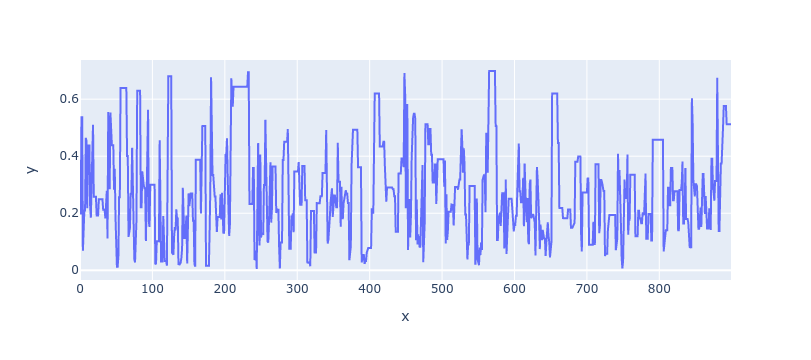

In [100]:
px.line(x=range(len(probs)), y = probs)

## MCMC point sample rate as importance

In [106]:
sample_rates = np.array([0 for i in range(len(set(segs)))])
for mask in masks:
    for idx in mask:
        sample_rates[idx] += 1
sample_rates =  1-sample_rates / len(masks)
seg_sample_rate = [sample_rates[i] for i in segs]

Explanation for label: bathtub


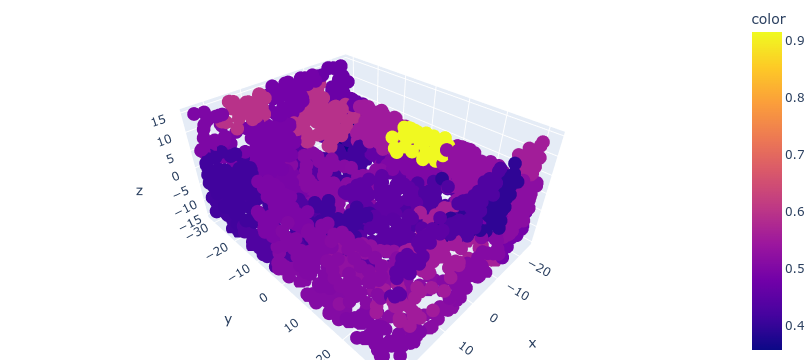

In [112]:
print("Explanation for label: " + class_map[6])
visualize_point_cloud(obj, seg_sample_rate)

## Let's see why the model think it is a sofa

In [114]:
masks, probs, labels = MCMC(total_iters=1000, burn_in_iters=100, step_len=13, index_of_interest=3,
                           obj=obj, segments=segs, model=pointnet_model)

100%|███████████████████████████████████| 1000/1000 [00:24<00:00, 41.62it/s]

Acceptance rate: 0.628


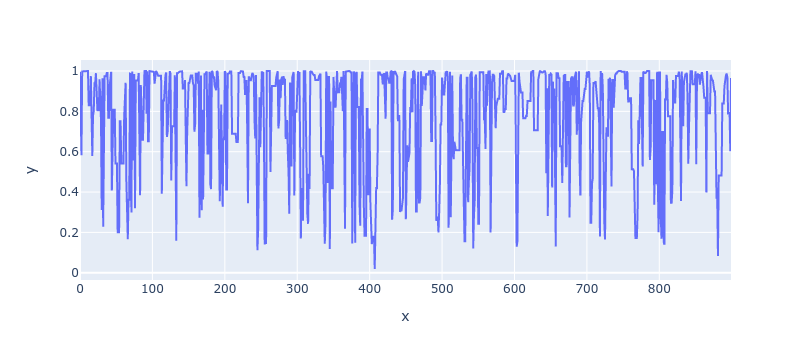

In [115]:
px.line(x=range(len(probs)), y = probs)

In [116]:
sample_rates = np.array([0 for i in range(len(set(segs)))])
for mask in masks:
    for idx in mask:
        sample_rates[idx] += 1
sample_rates =  1-sample_rates / len(masks)
seg_sample_rate = [sample_rates[i] for i in segs]

Explanation for label: sofa


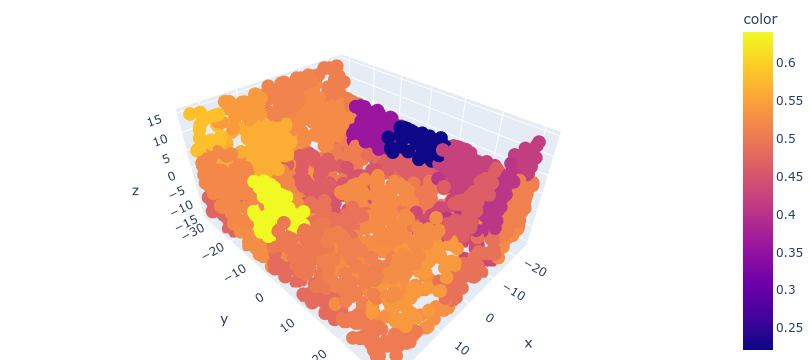

In [117]:
print("Explanation for label: " + class_map[3])
visualize_point_cloud(obj, seg_sample_rate)